<a href="https://colab.research.google.com/github/lamtranBKHN/PCB-defect-detector/blob/master/(80%2C80%2C3)VGG16_5600dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from imutils import paths
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.layers import Input
from keras.models import Model
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
import numpy as np
import random
import os
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from matplotlib import pyplot as plt
import cv2
import pickle

Using TensorFlow backend.


In [0]:
IMG_SIZE = 80

file_list = []
class_list = []

DATADIR = "Organized dataSet"

# All the categories neural network will detect
CATEGORIES = ["mouse bite","not","open","pin hole",
              "short","spur","spurious copper"]

# Checking or all images in the data folder
for category in CATEGORIES :
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)

training_data = []

def create_training_data():
    for category in CATEGORIES :
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()
random.shuffle(training_data)

X = [] #features
y = [] #labels

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)   
# Creating the files containing all the information about your model
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

# Opening the files about data
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalizing data (a pixel goes from 0 to 255)
X = X/255.0

In [4]:
# Load model VGG 16 
baseModel = VGG16(weights='imagenet', include_top=False, \
                  input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
# Buil layer
fcHead = baseModel.output
# Flatten 
fcHead = Flatten()(fcHead)
# Add FC
fcHead = Dense(512, activation='relu')(fcHead)
fcHead = Dropout(0.3)(fcHead)
# Output layer with softmax activation
fcHead = Dense(7, activation='softmax')(fcHead)
# modle
model = model = Model(inputs=baseModel.input, outputs=fcHead)

58892288/58889256 [==============================] - 2s 0us/step


Train on 5040 samples, validate on 560 samples
Epoch 1/150
5040/5040 [==============================] - 22s 4ms/step - loss: 1.9484 - accuracy: 0.2123 - val_loss: 1.6775 - val_accuracy: 0.4857
Epoch 2/150
5040/5040 [==============================] - 13s 3ms/step - loss: 1.6067 - accuracy: 0.4149 - val_loss: 1.3607 - val_accuracy: 0.6946
Epoch 3/150
5040/5040 [==============================] - 13s 3ms/step - loss: 1.3126 - accuracy: 0.5399 - val_loss: 1.0532 - val_accuracy: 0.7732
Epoch 4/150
5040/5040 [==============================] - 13s 3ms/step - loss: 1.0260 - accuracy: 0.6639 - val_loss: 0.7651 - val_accuracy: 0.8339
Epoch 5/150
5040/5040 [==============================] - 13s 3ms/step - loss: 0.7853 - accuracy: 0.7401 - val_loss: 0.5550 - val_accuracy: 0.8625
Epoch 6/150
5040/5040 [==============================] - 14s 3ms/step - loss: 0.6038 - accuracy: 0.8069 - val_loss: 0.4173 - val_accuracy: 0.8839
Epoch 7/150
5040/5040 [==============================] - 14s 3ms/step - loss:

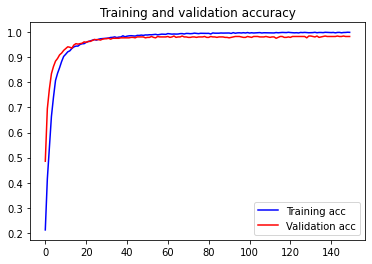

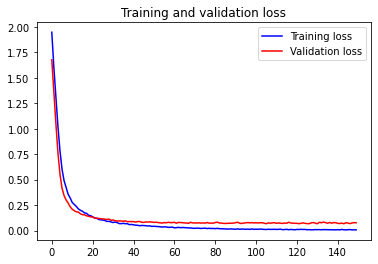

In [5]:
model.compile(loss = "sparse_categorical_crossentropy", 
                    optimizer = SGD(lr=1e-5, momentum=0.9), 
                    metrics=["accuracy"])
# Training the model.
X = np.array(X)
y = np.array(y)
history = model.fit(X, y, batch_size=32, epochs=120, validation_split=0.1)

# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
    json_file.write(model_json)

model.save_weights("model2.h5")
print("Saved model to disk")

model.save('CNN2.model')

# Printing a graph showing the accuracy changes during the training phase
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model = tf.keras.models.load_model("CNN2.model")
hsv_lower = np.array([0, 150, 150])
hsv_upper = np.array([10, 255, 255])


def test(originalFileName, testFileName, required_size=(IMG_SIZE, IMG_SIZE)):
  origin = cv2.imread(originalFileName)
  temp = cv2.imread(testFileName)
  difference = cv2.bitwise_xor(origin, temp, mask=None)
  Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
  ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 
                            255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  difference[mask != 255] = [0, 0, 255]
  origin[mask != 255] = [0, 0, 255]
  temp[mask != 255] = [0, 0, 255]
  hsv = cv2.cvtColor(origin, cv2.COLOR_BGR2HSV)
  mask = cv2.inRange(hsv, hsv_lower, hsv_upper)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
  close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
  cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  offset = 20
  ROI_number = 0
  for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    ROI = origin[y - offset:y + h + offset, x - offset:x + w + offset]
    try:
      ROI = cv2.resize(ROI, (IMG_SIZE, IMG_SIZE))
      ROI = ROI.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
      prediction = model.predict([ROI])
      prediction = list(prediction[0])
      if prediction.index(max(prediction)) != 1:
        cv2.rectangle(temp, (x - offset, y - offset), 
                    (x + w + offset, y + h + offset), (36, 255, 12), 2)
        cv2.putText(temp,CATEGORIES[prediction.index(max(prediction))],
                (x - offset, y - offset), 0, 1, 
                (255, 0, 255),2, cv2.LINE_AA)
    except cv2.error as e:
      ROI_number += 1
    ROI_number += 1
  plt.imshow(temp) 
  plt.show()
      

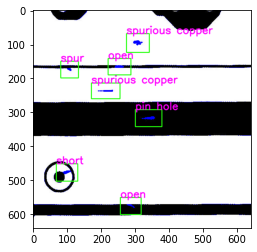

In [56]:
test('temp.jpg', 'test.jpg')

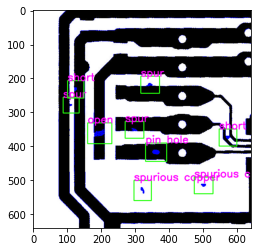

In [39]:
test('temp1.jpg', 'test1.jpg')

In [0]:
test('temp2.jpg', 'test2.jpg')

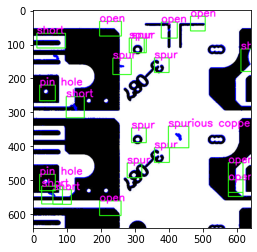

In [60]:
test('temp3.jpg', 'test3.jpg')

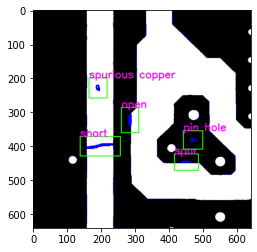

In [62]:
test('temp4.jpg', 'test4.jpg')